# 1. Импорт библиотек

In [1]:
# Импортируем библиотеки
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score, roc_curve, confusion_matrix, plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve
from math import log as log
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import f_classif, mutual_info_classif
from pandas import Series
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
DATA_DIR = '/kaggle/input/sf-dst-scoring/'

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [2]:
# Функции

# Функция выводит базовую информацию по переменным, строит графики распределения и 
# боксплоты, в том числе и для логарифмированной переменной 
def basic_inf(x, y):

    df = y

    display(df[x].describe())

    fig, axes = plt.subplots(2, 2, figsize=(18, 10))
    axes[0, 0].hist(df[x], bins=100)
    axes[0, 0].set_title(x)
    sns.boxplot(ax=axes[0, 1], y=df[x])
    axes[0, 1].set_title(x)
    axes[1, 0].hist(np.log(df[x][df[x] > 0]), bins=100)
    axes[1, 0].set_title(f'Логарифм {x}')
    sns.boxplot(y=np.log(df[x][df[x] > 0]))
    axes[1, 1].set_title(f'Логарифм {x}')

    median = df[x].median()
    IQR = df[x].quantile(0.75) - df[x].quantile(0.25)
    perc25 = df[x].quantile(0.25)
    perc75 = df[x].quantile(0.75)
    f = perc25 - 1.5*IQR,
    l = perc75 + 1.5*IQR
    print('Медиана: {}\n'.format(median),
          '25-й перцентиль: {}\n'.format(perc25),
          '75-й перцентиль: {}\n'.format(perc75),
          "IQR: {} \n".format(IQR),
          f"Границы выбросов: [{f}, {l}].\n",
          f'Количество значений за левой границей: {df[x][df[x]<f].count()}\n',
          f'Количество значений за правой границей: {df[x][df[x]>l].count()} \n')
    log_df = np.log(df[x]+1)
    log_median = log_df.median()
    log_IQR = log_df.quantile(0.75) - log_df.quantile(0.25)
    log_perc25 = log_df.quantile(0.25)
    log_perc75 = log_df.quantile(0.75)
    log_f = log_perc25 - 1.5*log_IQR,
    log_l = log_perc75 + 1.5*log_IQR
    print('Для логарифма:\n',
          'Медиана: {}\n'.format(log_median),
          '25-й перцентиль: {}\n'.format(log_perc25),
          '75-й перцентиль: {}\n'.format(log_perc75),
          "IQR: {}\n".format(log_IQR),
          f"Границы выбросов: [{log_f}, {log_l}].\n"
          f'Количество значений за левой границей: {log_df[log_df<log_f].count()}\n',
          f'Количество значений за правой границей: {log_df[log_df>log_l].count()} \n'
          )

In [3]:
# Вывод всех метрик и построение confusion matrix, кривой precision-recall и ROC-curve,
# Так же добавляет в отдельный датафрейм модель,ее описание и все метрики
def all_metrics(name, model, X, y_true):
    y_pred = model.predict(X)
    y_pred_prob = model.predict_proba(X)[:, 1]
    results = pd.DataFrame(
        {
            'Model': str(model),
            'Accuracy': accuracy_score(y_true, y_pred),
            'Balanced accuracy score': balanced_accuracy_score(y_true, y_pred),
            'Precision': precision_score(y_true, y_pred),
            'Recall': recall_score(y_true, y_pred),
            'F1-score': f1_score(y_true, y_pred),
            'ROC_AUC': roc_auc_score(y_true, y_pred_prob)
        }, index=[name])
    plot_confusion_matrix(model, X, y_true)
    plot_precision_recall_curve(model, X, y_true)
    plot_roc_curve(model, X, y_true)
    return results


results = []

In [4]:
RANDOM_SEED = 42

# 2. Импорт данных

In [5]:
df_train = pd.read_csv(DATA_DIR+'train.csv')
df_test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')
print(f'Размер тренировочного датасета {df_train.shape}')
print(f'Размер тестового датасета {df_test.shape}')

Размер тренировочного датасета (73799, 19)
Размер тестового датасета (36349, 18)


In [6]:
# Объединим трейн и тест в один датасет
df_train['train'] = 1  # помечаем где у нас трейн
df_test['train'] = 0  # помечаем где у нас тест

# Объединяем
df = df_train.append(df_test, sort=False).reset_index(drop=True)
df.head(2)

client_id   app_date education sex  age car car_type  decline_app_cnt  \
0      25905  01FEB2014       SCH   M   62   Y        Y                0   
1      63161  12MAR2014       SCH   F   59   N        N                0   

   good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0          0  -2.008753                1             50             1   
1          0  -1.532276                3             50             2   

   work_address  income  sna  first_time foreign_passport  default  train  
0             2   18000    4           1                N      0.0      1  
1             3   19000    4           1                N      0.0      1

# 3. Предварительный анализ данных


In [7]:
# Посмотрим на имеющиеся данные
pandas_profiling.ProfileReport(df[df['train'] == 1])


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4446: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Summarize dataset:   0%|          | 0/34 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
# Просмотр пропусков в тестовом датасете
df[df['train'] == 0].isnull().sum()

client_id               0
app_date                0
education             171
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
train                   0
dtype: int64

## Предварительный анализ
Предварительный анализ показал: в тренировочном датасете 73799 записей, в тестовой - 36349 записей. 
В датасете представленно 20 переменных, из них: 1 временной ряд, 6 бинарных, 7 категориальных и 8 числовых.
Всего 307 пропусков в переменной education в тренировочном датасете и 171 в тестовом.

Описания полей датасета

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

In [9]:
# Вынесем названия переменных в списки
# Временной ряд
time_cols = ['app_date']
# Бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
# Категориальные переменные
cat_cols = ['education', 'region_rating',
            'home_address', 'work_address', 'sna', 'first_time']
# Числовые переменные, client_id исключили из списка
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']


# 4. Анализ переменных

### 1. client_id

Идентификатор клиента, не несет полезной информации


#### 2. app_date

In [10]:
# Преобразуем формат в подходящий нам
df['app_date'] = pd.to_datetime(df['app_date'], format='%d%b%Y')

# Найдем максимальную и минимальную дату
min_date = df['app_date'].min()
max_date = df['app_date'].max()
print(f'Минимальныя дата: {min_date}\nМаксимальная дата {max_date}')

Минимальныя дата: 2014-01-01 00:00:00
Максимальная дата 2014-04-30 00:00:00


В нашем датасете представлены заявки за первые 4 месяца 2014 года

#### 3. education

<AxesSubplot:>

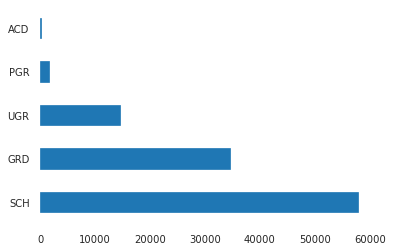

In [11]:
# Смотрим распределение переменной
df['education'].value_counts().plot.barh()

In [12]:
# Пропущенные значения
df['education'].isnull().sum()

478

In [13]:
# Заменяем пропущенные значения модой
df['education'] = df['education'].fillna(df['education'].mode().values[0])

In [14]:
# Проверяем заполнение
df['education'].isnull().sum()

0

In [15]:
df['education'].value_counts()

SCH    58476
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

Обработка бинарных и категориальных признаков будет произведена позже

#### 4. sex

<AxesSubplot:>

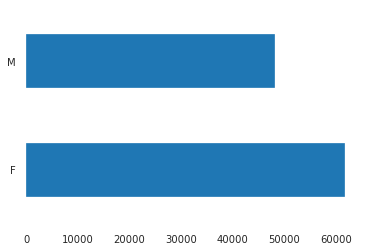

In [16]:
# Смотрим распределение переменной
df['sex'].value_counts().plot.barh()

####  5. age

count    73799.000000
mean        39.280641
std         11.520378
min         21.000000
25%         30.000000
50%         37.000000
75%         48.000000
max         72.000000
Name: age, dtype: float64

Медиана: 37.0
 25-й перцентиль: 30.0
 75-й перцентиль: 48.0
 IQR: 18.0 
 Границы выбросов: [(3.0,), 75.0].
 Количество значений за левой границей: 0
 Количество значений за правой границей: 0 

Для логарифма:
 Медиана: 3.6375861597263857
 25-й перцентиль: 3.4339872044851463
 75-й перцентиль: 3.8918202981106265
 IQR: 0.4578330936254802
 Границы выбросов: [(2.7472375640469258,), 4.5785699385488465].
Количество значений за левой границей: 0
 Количество значений за правой границей: 0 



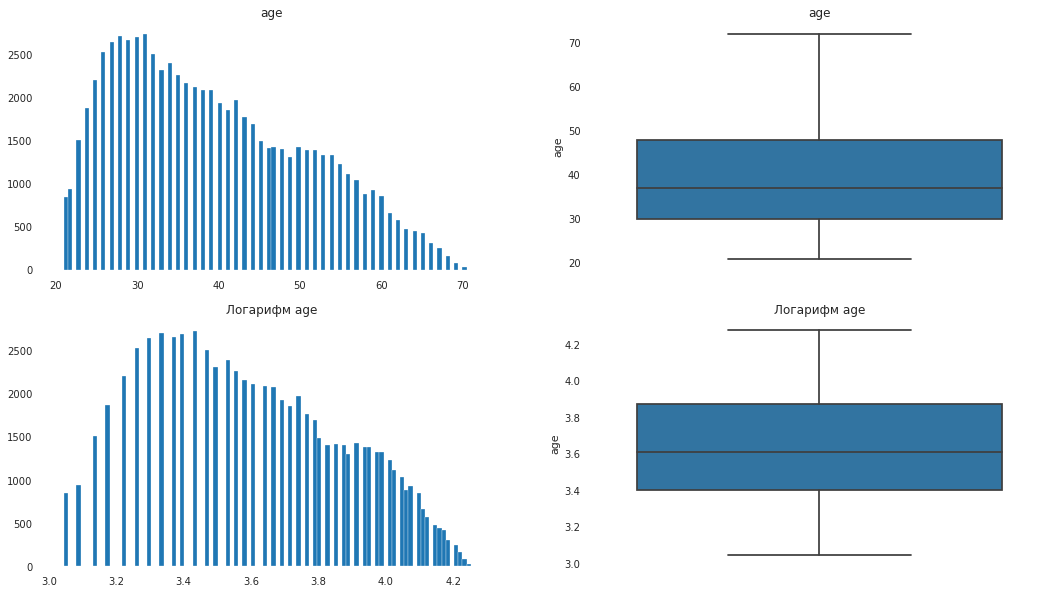

In [17]:
# Смотрим информацию о переменной
basic_inf('age', df[df['train'] == 1])

Выбросов нет

In [18]:
# Для дальнейшей работы будем использовать логарифм от признака
df['age'] = np.log(df['age']+1)

#### 6. car

<AxesSubplot:>

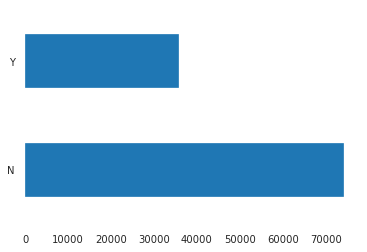

In [19]:
# Смотрим распределение переменной
df['car'].value_counts().plot.barh()

####  7. car_type

<AxesSubplot:>

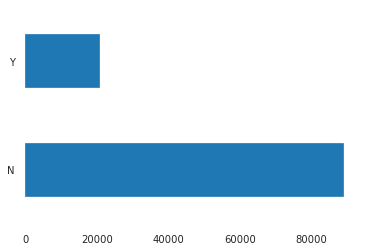

In [20]:
# Смотрим распределение переменной
df['car_type'].value_counts().plot.barh()

#### 8. decline_app_cnt

count    73799.000000
mean         0.275749
std          0.804272
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         33.000000
Name: decline_app_cnt, dtype: float64

Медиана: 0.0
 25-й перцентиль: 0.0
 75-й перцентиль: 0.0
 IQR: 0.0 
 Границы выбросов: [(0.0,), 0.0].
 Количество значений за левой границей: 0
 Количество значений за правой границей: 12585 

Для логарифма:
 Медиана: 0.0
 25-й перцентиль: 0.0
 75-й перцентиль: 0.0
 IQR: 0.0
 Границы выбросов: [(0.0,), 0.0].
Количество значений за левой границей: 0
 Количество значений за правой границей: 12585 



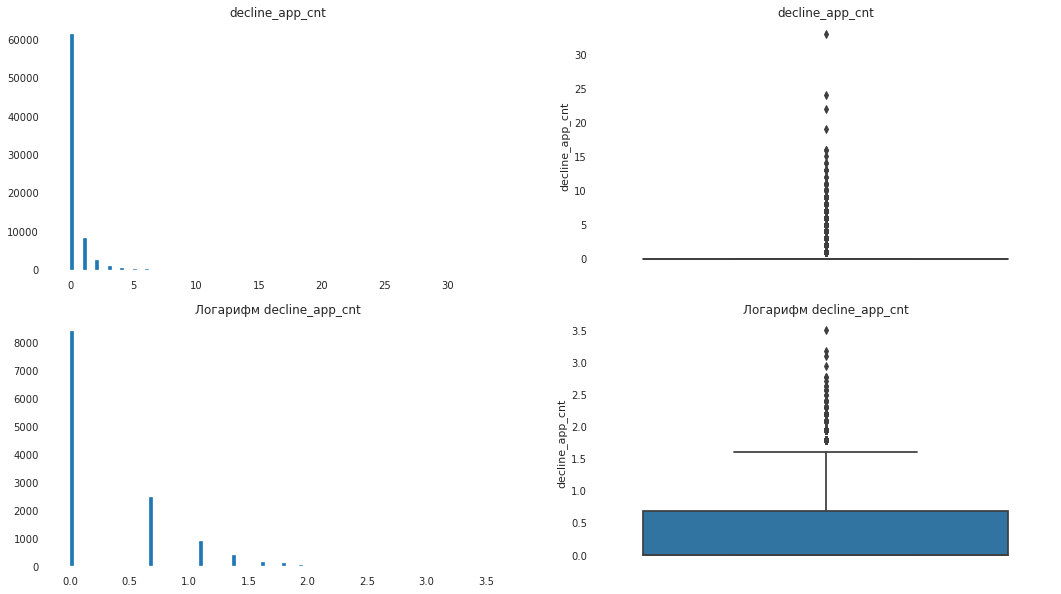

In [21]:
# Смотрим информацию о переменной
basic_inf('decline_app_cnt', df[df['train'] == 1])

Выбросов много, поэтому осталяем как есть

In [22]:
# Для дальнейшей работы будем использовать логарифм от признака
df['decline_app_cnt'] = np.log(df['decline_app_cnt'] + 1)

#### 9. good_work

<AxesSubplot:>

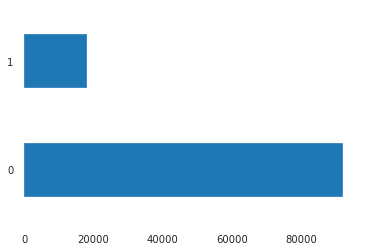

In [23]:
# Смотрим распределение переменной
df['good_work'].value_counts().plot.barh()

#### 10. score_bki

count    73799.000000
mean        -1.904724
std          0.498231
min         -3.624586
25%         -2.259534
50%         -1.920823
75%         -1.569831
max          0.199773
Name: score_bki, dtype: float64

Медиана: -1.92082293
 25-й перцентиль: -2.259533835
 75-й перцентиль: -1.56983126
 IQR: 0.6897025750000001 
 Границы выбросов: [(-3.2940876975,), -0.5352773974999998].
 Количество значений за левой границей: 52
 Количество значений за правой границей: 299 

Для логарифма:
 Медиана: -1.8653056020498648
 25-й перцентиль: -2.734417331169273
 75-й перцентиль: -1.226142450432966
 IQR: 1.5082748807363069
 Границы выбросов: [(-4.996829652273734,), 1.0362698706714941].
Количество значений за левой границей: 85
 Количество значений за правой границей: 0 



/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


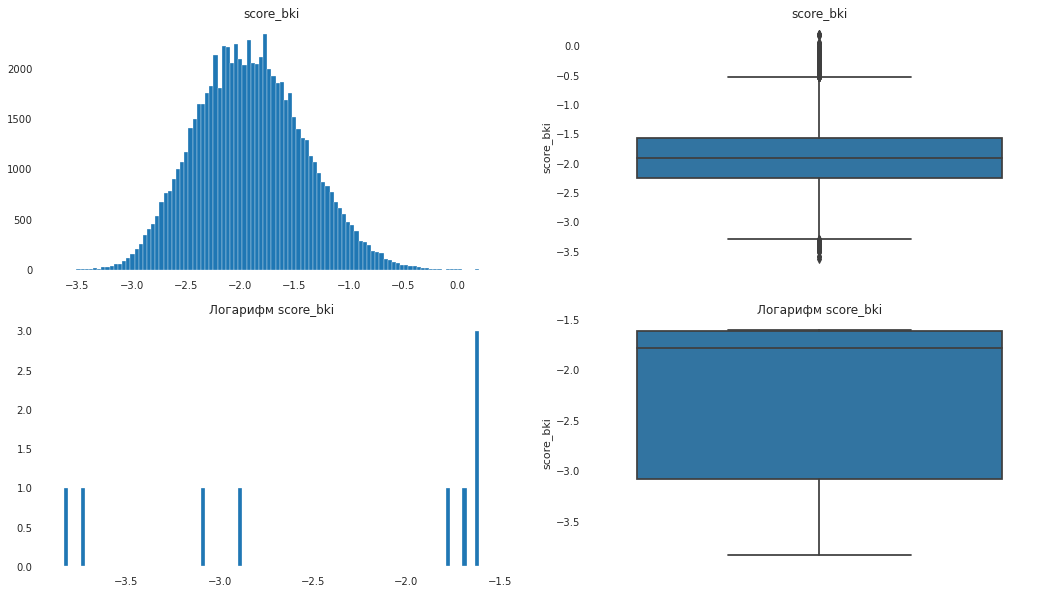

In [24]:
# Смотрим информацию о переменной
basic_inf('score_bki', df[df['train'] == 1])

Выбросов не много, можно не удалять

####  11. bki_request_cnt

count    73799.000000
mean         2.000339
std          2.252073
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         53.000000
Name: bki_request_cnt, dtype: float64

Медиана: 1.0
 25-й перцентиль: 0.0
 75-й перцентиль: 3.0
 IQR: 3.0 
 Границы выбросов: [(-4.5,), 7.5].
 Количество значений за левой границей: 0
 Количество значений за правой границей: 1755 

Для логарифма:
 Медиана: 0.6931471805599453
 25-й перцентиль: 0.0
 75-й перцентиль: 1.3862943611198906
 IQR: 1.3862943611198906
 Границы выбросов: [(-2.0794415416798357,), 3.465735902799726].
Количество значений за левой границей: 0
 Количество значений за правой границей: 9 



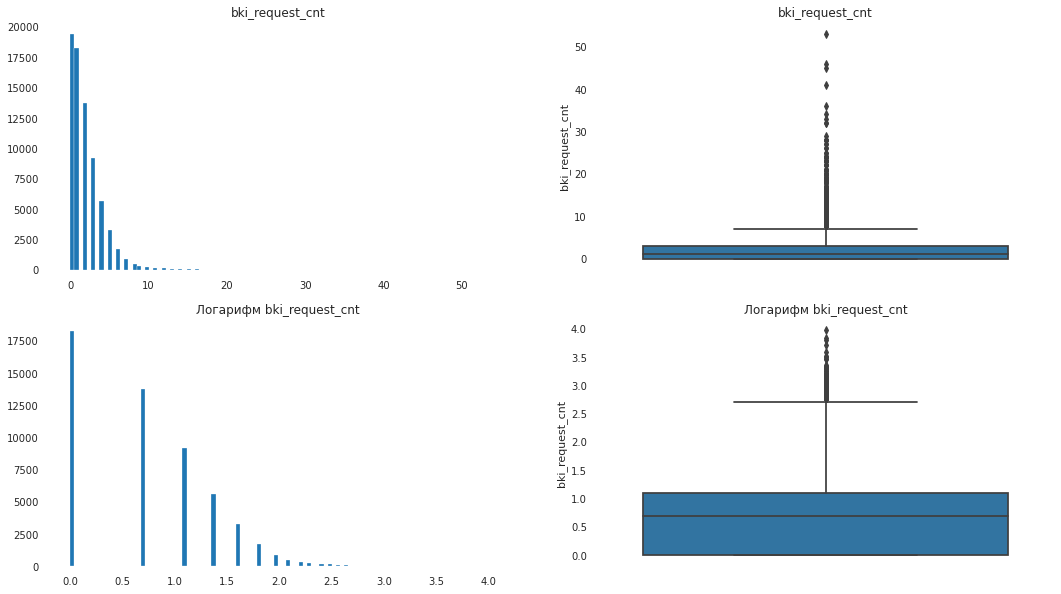

In [25]:
# Смотрим информацию о переменной
basic_inf('bki_request_cnt', df[df['train'] == 1])

Выбросов не много, оставляем

In [26]:
# Для дальнейшей работы будем использовать логарифм от признака
df['bki_request_cnt'] = np.log(df['bki_request_cnt'] + 1)

#### 12. region_rating

count    73799.000000
mean        56.725701
std         13.055717
min         20.000000
25%         50.000000
50%         50.000000
75%         60.000000
max         80.000000
Name: region_rating, dtype: float64

Медиана: 50.0
 25-й перцентиль: 50.0
 75-й перцентиль: 60.0
 IQR: 10.0 
 Границы выбросов: [(35.0,), 75.0].
 Количество значений за левой границей: 506
 Количество значений за правой границей: 11469 

Для логарифма:
 Медиана: 3.9318256327243257
 25-й перцентиль: 3.9318256327243257
 75-й перцентиль: 4.110873864173311
 IQR: 0.17904823144898563
 Границы выбросов: [(3.663253285550847,), 4.37944621134679].
Количество значений за левой границей: 506
 Количество значений за правой границей: 11469 



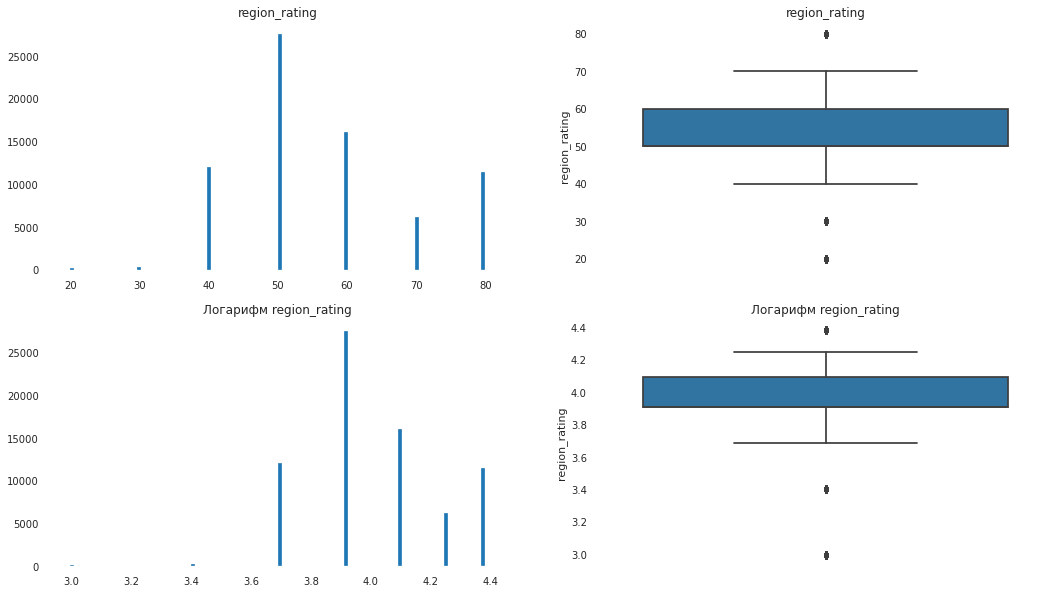

In [27]:
# Смотрим информацию о переменной
basic_inf('region_rating', df[df['train'] == 1])

Используем как категориальный признак

#### 13. home_address

In [28]:
# Смотрим распределение переменной
df['home_address'].value_counts()

2    59591
1    48688
3     1869
Name: home_address, dtype: int64

#### 14. work_address

In [29]:
# Смотрим распределение переменной
df['work_address'].value_counts()

3    67113
2    30761
1    12274
Name: work_address, dtype: int64

#### 15. income

count      73799.000000
mean       41099.775417
std        46166.322400
min         1000.000000
25%        20000.000000
50%        30000.000000
75%        48000.000000
max      1000000.000000
Name: income, dtype: float64

Медиана: 30000.0
 25-й перцентиль: 20000.0
 75-й перцентиль: 48000.0
 IQR: 28000.0 
 Границы выбросов: [(-22000.0,), 90000.0].
 Количество значений за левой границей: 0
 Количество значений за правой границей: 4695 

Для логарифма:
 Медиана: 10.308985993422082
 25-й перцентиль: 9.90353755128617
 75-й перцентиль: 10.778977123006351
 IQR: 0.8754395717201806
 Границы выбросов: [(8.590378193705899,), 12.092136480586621].
Количество значений за левой границей: 595
 Количество значений за правой границей: 1172 



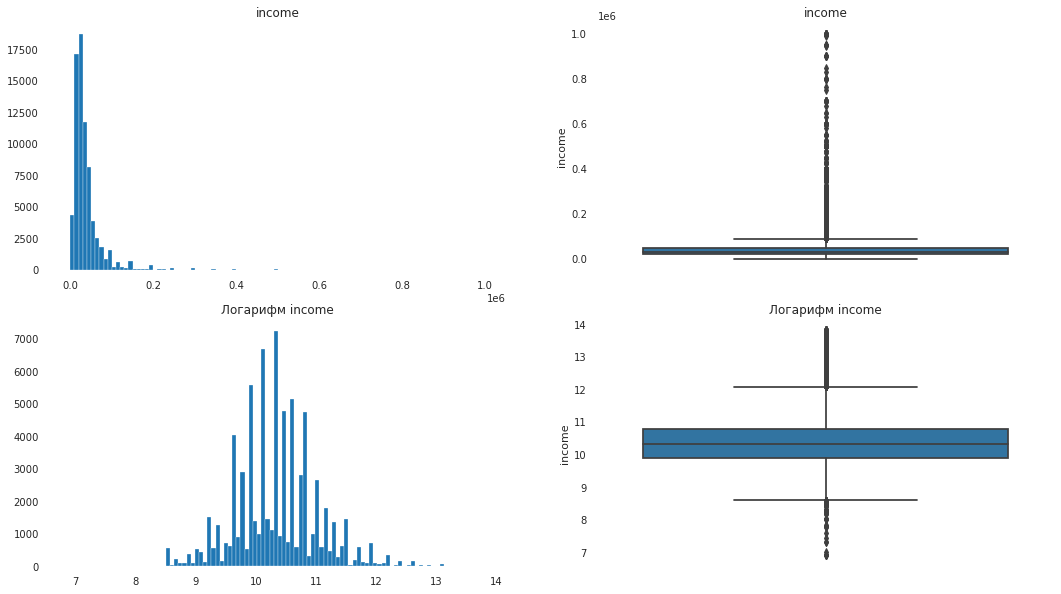

In [30]:
# Смотрим информацию о переменной
basic_inf('income', df[df['train'] == 1])

Выбросы оставляем

In [31]:
# Для дальнейшей работы будем использовать логарифм от признака
df['income'] = np.log(df['income'] + 1)

#### 16. sna

<AxesSubplot:>

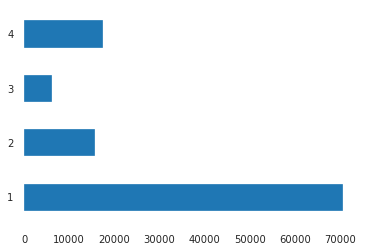

In [32]:
# Смотрим распределение переменной
df['sna'].value_counts().plot.barh()

#### 17. first_time

<AxesSubplot:>

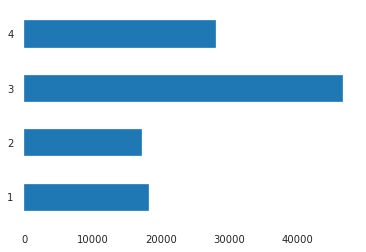

In [33]:
# Смотрим распределение переменной
df['first_time'].value_counts().plot.barh()

#### 18. foreign_passport

<AxesSubplot:>

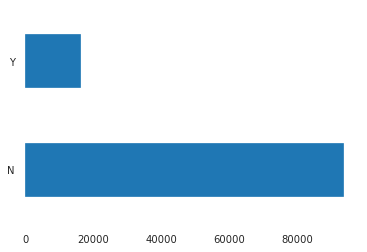

In [34]:
# Смотрим распределение переменной
df['foreign_passport'].value_counts().plot.barh()

#### 19. default

<AxesSubplot:>

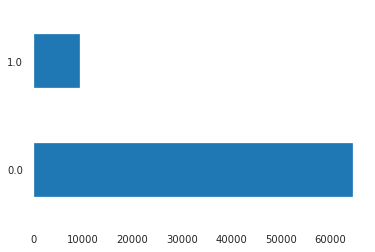

In [35]:
df['default'].value_counts().plot.barh()

## Создание новых признаков

In [36]:
# Создадим новый признак: номер дня от минимальной даты
df['date_delta'] = (df.app_date - min_date).dt.days.astype('int')

count    110148.000000
mean         60.971466
std          32.076078
min           0.000000
25%          33.000000
50%          62.000000
75%          89.000000
max         119.000000
Name: date_delta, dtype: float64

Медиана: 62.0
 25-й перцентиль: 33.0
 75-й перцентиль: 89.0
 IQR: 56.0 
 Границы выбросов: [(-51.0,), 173.0].
 Количество значений за левой границей: 0
 Количество значений за правой границей: 0 

Для логарифма:
 Медиана: 4.143134726391533
 25-й перцентиль: 3.5263605246161616
 75-й перцентиль: 4.499809670330265
 IQR: 0.9734491457141035
 Границы выбросов: [(2.0661868060450064,), 5.959983388901421].
Количество значений за левой границей: 2311
 Количество значений за правой границей: 0 



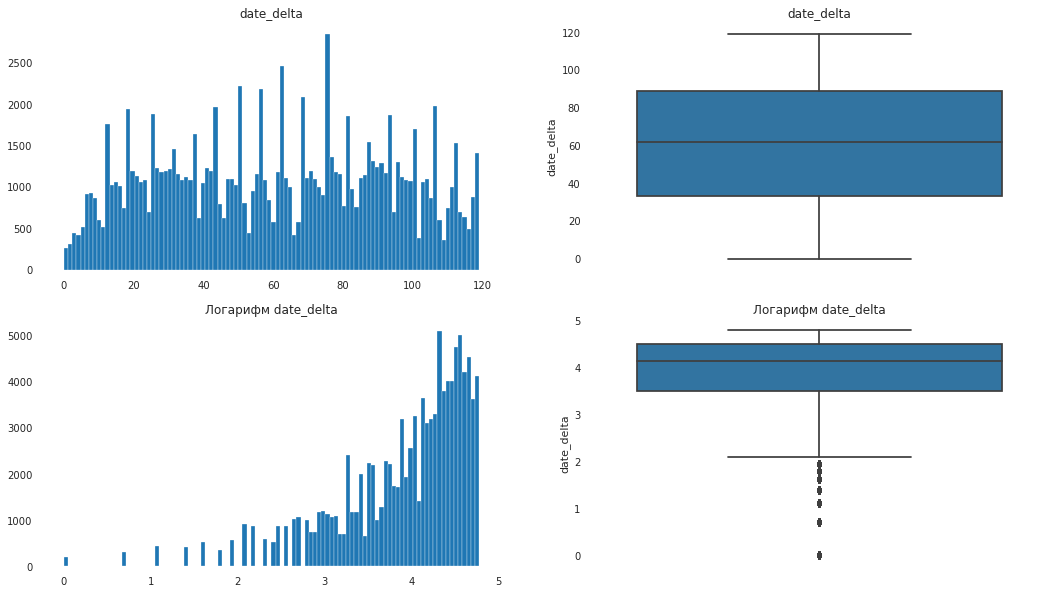

In [37]:
# Посмотрим на распределение признака
basic_inf('date_delta', df)

In [38]:
# Признак числовой, добавим в список числовых переменных
num_cols.append('date_delta')

## Преобразование переменных

#### Преобразуем переменную education


In [39]:
le = LabelEncoder()
df['education'] = le.fit_transform(df['education'])
df['education'].value_counts()

3    58476
1    34768
4    14748
2     1865
0      291
Name: education, dtype: int64

#### Преобразуем бинарные переменные

In [40]:
for column in bin_cols:
    df[column] = le.fit_transform(df[column])

## Анализ зависимостей числовых переменных


### Построим матрицу корреляции для числовых переменных


<AxesSubplot:>

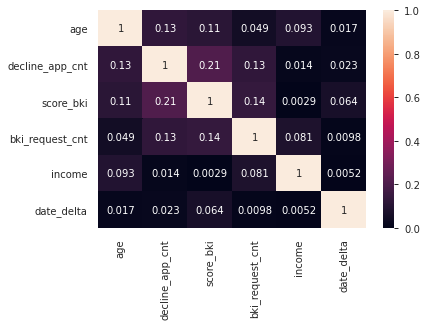

In [41]:
train_data = df[df['train'] == 1]
sns.heatmap(train_data[num_cols].corr().abs(), vmin=0, vmax=1, annot=True)

Значимой корреляции между переменными не наблюдается


### Построим boxplot’ы для численных переменных


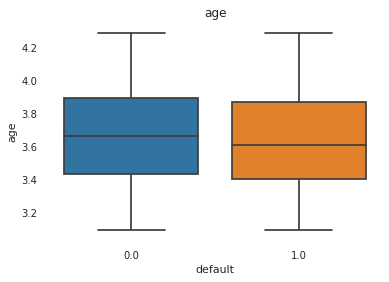

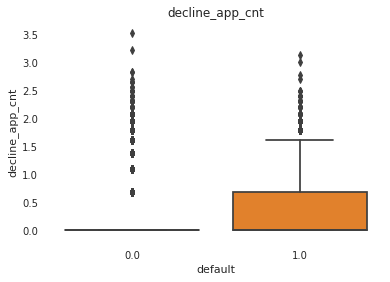

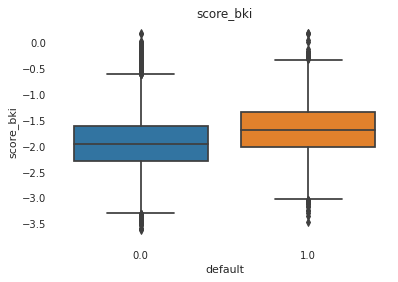

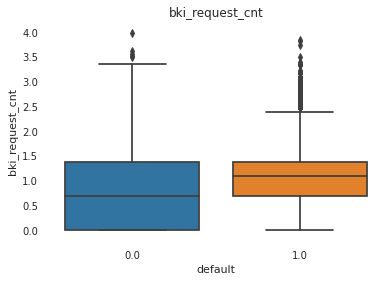

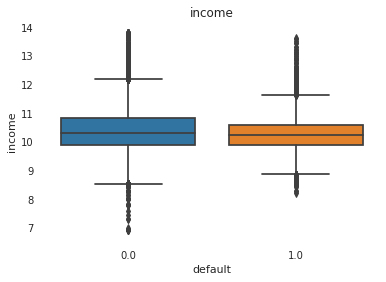

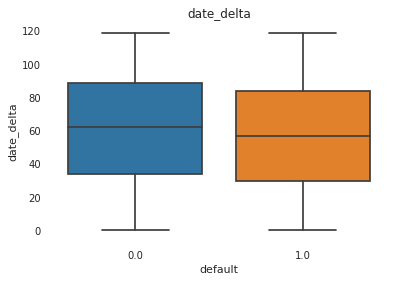

In [42]:
for i in num_cols:
    plt.figure()
    sns.boxplot(x='default', y=train_data[i], data=train_data,)
    plt.title(i)
    plt.show()

Дефолтные клиенты в среднем:

1)младше

2)имеют большее количество отмененных заявок 

3)имеют больше запросов в БКИ

4)имеют более низкий доход


### Значимость непрерывных переменных

<AxesSubplot:>

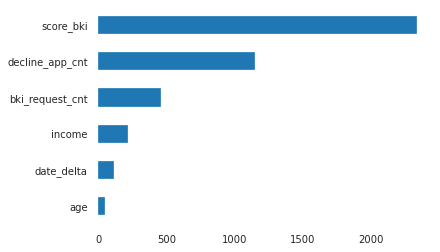

In [43]:
# В качестве меры значимости мы будем использовать значение f-статистики
imp_num = Series(f_classif(train_data[num_cols], train_data['default'])[
                 0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

Наибольшую значимость имеет признак score_bki

### Значимость категориальных и бинарных переменных

<AxesSubplot:>

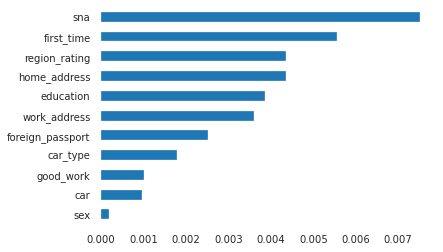

In [44]:
# Для оценки значимости категориальных и бинарных переменных будем использовать функцию mutual_info_classif из библиотеки sklearn
imp_cat = Series(mutual_info_classif(train_data[bin_cols + cat_cols], train_data['default'],
                                     discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Наибольшую значимость имеет признак sna

## Подготовка данных

### Стандартизация


In [45]:
# Стандартизируем численные переменные
ss = StandardScaler()
df[num_cols] = pd.DataFrame(ss.fit_transform(
    df[num_cols]), columns=df[num_cols].columns)

In [46]:
df[num_cols].describe()

age  decline_app_cnt     score_bki  bki_request_cnt  \
count  1.101480e+05     1.101480e+05  1.101480e+05     1.101480e+05   
mean   1.004110e-15    -3.789093e-15 -4.903485e-16     3.587481e-16   
std    1.000005e+00     1.000005e+00  1.000005e+00     1.000005e+00   
min   -1.976836e+00    -4.188152e-01 -3.444269e+00    -1.334144e+00   
25%   -7.737452e-01    -4.188152e-01 -7.126592e-01    -1.334144e+00   
50%   -5.949589e-02    -4.188152e-01 -3.261521e-02    -2.817904e-01   
75%    8.323877e-01    -4.188152e-01  6.741092e-01     7.705631e-01   
max    2.230861e+00     9.340604e+00  4.213712e+00     4.722032e+00   

             income    date_delta  
count  1.101480e+05  1.101480e+05  
mean   7.210120e-16 -1.470299e-16  
std    1.000005e+00  1.000005e+00  
min   -4.933787e+00 -1.900848e+00  
25%   -6.348458e-01 -8.720390e-01  
50%   -5.283405e-02  3.206561e-02  
75%    6.218273e-01  8.738182e-01  
max    4.980702e+00  1.809099e+00

### One-hot encoding

In [47]:
# Преобразуем категориальные переменные
df = pd.get_dummies(df, prefix=cat_cols, columns=cat_cols)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 41 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         110148 non-null  int64         
 1   app_date          110148 non-null  datetime64[ns]
 2   sex               110148 non-null  int64         
 3   age               110148 non-null  float64       
 4   car               110148 non-null  int64         
 5   car_type          110148 non-null  int64         
 6   decline_app_cnt   110148 non-null  float64       
 7   good_work         110148 non-null  int64         
 8   score_bki         110148 non-null  float64       
 9   bki_request_cnt   110148 non-null  float64       
 10  income            110148 non-null  float64       
 11  foreign_passport  110148 non-null  int64         
 12  default           73799 non-null   float64       
 13  train             110148 non-null  int64         
 14  date

## Модель

#### Разбиваем датасет на тренировочный и тестовый


In [49]:
data_train = df.query('train == 1').drop(
    ['train', 'client_id', 'app_date'], axis=1)
data_test = df.query('train == 0').drop(
    ['train', 'client_id', 'app_date'], axis=1)

X = data_train.drop(['default'], axis=1)
y = data_train['default'].values

In [50]:
# Разбиваем данные с помощью train_test_split, для валидации берем 20%
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

In [51]:
# Проверяем
data_test.shape, data_train.shape, X.shape, X_train.shape, X_test.shape

((36349, 38), (73799, 38), (73799, 37), (59039, 37), (14760, 37))

#### Обучаем модель на стандартных настройках логистической регрессии

In [52]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [53]:
y_pred = log_reg.predict(X_test)
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

#### Оценка качества модели

Model  \
Логистическая регрессия на стандартных параметрах  LogisticRegression()   

                                                   Accuracy  \
Логистическая регрессия на стандартных параметрах  0.874729   

                                                   Balanced accuracy score  \
Логистическая регрессия на стандартных параметрах                 0.508785   

                                                   Precision    Recall  \
Логистическая регрессия на стандартных параметрах   0.394231  0.022441   

                                                   F1-score   ROC_AUC  
Логистическая регрессия на стандартных параметрах  0.042465  0.744768

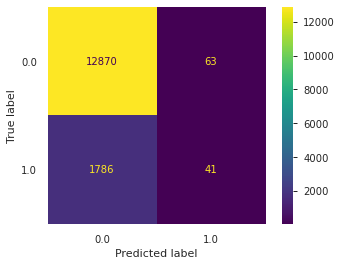

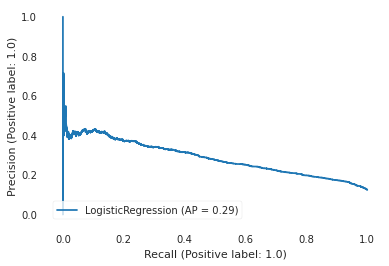

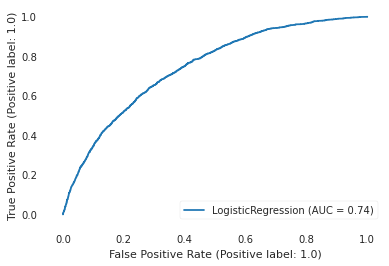

In [54]:
# Выведем все метрики
results = all_metrics('Логистическая регрессия на стандартных параметрах',
                      log_reg, X_test, y_test)
results

F-1 score показывает, что данная модель абсолютно не годится для реальных задач, хотя метрика ROC-AUC достаточно высока.
Модель не угадывает дефолтных клиентов, тем самым мы можем принести банку очень большие убытки

#### Регуляризация

In [55]:
# Подберем оптимальные параметры для модели
model = LogisticRegression(random_state=42)
param_grid = [
    {'penalty': ['l1'],
     'solver': ['liblinear', 'lbfgs'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr']},
    {'penalty': ['l2'],
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr']},
    {'penalty': ['none'],
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr']}]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
# печатаем параметры
best_parameters = model.get_params()

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.34026794        nan
 0.34026794        nan 0.05541069 0.05518077        nan 0.05541069
 0.05541069 0.05541069 0.05518077        nan 0.05541069 0.05541069
 0.3402248  0.34022401 0.34023598 0.34021309 0.34021309 0.3402248
 0.34022401 0.34023598 0.34021309 0.34021309 0.05540439 0.05540439
 0.05540439 0.05540439 0.05540439 0.05540439 0.05540439 0.05540439
 0.34018937 0.34016612 0.34016652 0.34018937 0.34018937 0.34016612
 0.34016652 0.34018937]
  category=UserWarning


In [56]:
best_parameters

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': 42,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [57]:
# Пробуем обучить модель на данных параметрах
log_reg_2 = LogisticRegression(C=1.0,
                               class_weight='balanced',
                               dual=False,
                               fit_intercept=True,
                               intercept_scaling=1,
                               l1_ratio=None,
                               max_iter=100,
                               multi_class='auto',
                               n_jobs=None,
                               penalty='l1',
                               random_state=42,
                               solver='liblinear',
                               tol=0.0001,
                               verbose=0,
                               warm_start=False)

log_reg_2.fit(X_train, y_train)
y_pred = log_reg_2.predict(X_test)
y_pred_prob = log_reg_2.predict_proba(X_test)[:, 1]

Model  \
Логистическая регрессия на стандартных параметрах                                LogisticRegression()   
Логистическая регрессия с заданными гиперпараме...  LogisticRegression(class_weight='balanced', pe...   

                                                    Accuracy  \
Логистическая регрессия на стандартных параметрах   0.874729   
Логистическая регрессия с заданными гиперпараме...  0.671070   

                                                    Balanced accuracy score  \
Логистическая регрессия на стандартных параметрах                  0.508785   
Логистическая регрессия с заданными гиперпараме...                 0.678110   

                                                    Precision    Recall  \
Логистическая регрессия на стандартных параметрах    0.394231  0.022441   
Логистическая регрессия с заданными гиперпараме...   0.226715  0.687466   

                                                    F1-score   ROC_AUC  
Логистическая регрессия на стандартных параметрах   0.042465  0.744768  
Логистическая регрессия с заданными гиперпараме...  0.340980  0.744241

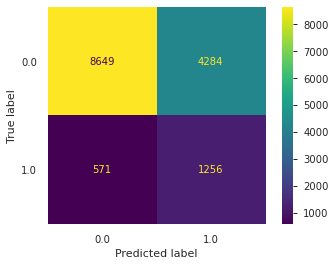

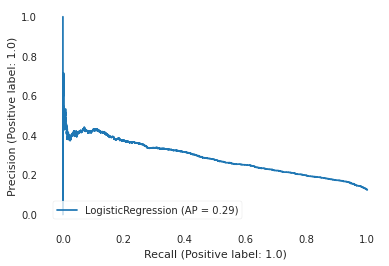

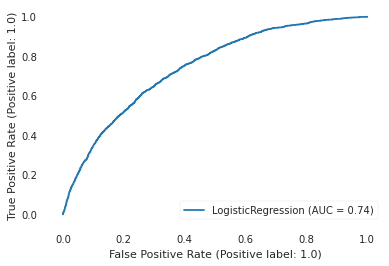

In [58]:
results = results.append(all_metrics(
    'Логистическая регрессия с заданными гиперпараметрами', log_reg_2, X_test, y_test))
results

Метрики F-1 и Recall значительно выросли, по сравнению с первой моделью. Так же выросла метрика balanced accuracy. Матрица ошибок показывает, что модель начала намного лучше угадывать дефолтных клиентов

# Submission


In [59]:
data_train = df.query('train == 1').drop(
    ['train', 'client_id', 'app_date'], axis=1)
data_test = df.query('train == 0').drop(
    ['train', 'client_id', 'app_date'], axis=1)

In [60]:
X_train = data_train.drop(['default'], axis=1)
y_train = data_train['default'].values
X_test = data_test.drop(['default'], axis=1)

In [61]:
log_reg = LogisticRegression(C=1.0,
                             class_weight='balanced',
                             dual=False,
                             fit_intercept=True,
                             intercept_scaling=1,
                             l1_ratio=None,
                             max_iter=100,
                             multi_class='auto',
                             n_jobs=None,
                             penalty='l1',
                             random_state=42,
                             solver='liblinear',
                             tol=0.0001,
                             verbose=0,
                             warm_start=False)

log_reg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', penalty='l1', random_state=42,
                   solver='liblinear')

In [62]:
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

In [63]:
submit = pd.DataFrame(df.query('train == 0')['client_id'])
submit['default'] = y_pred_prob
submit.to_csv('submission.csv', index=False)